In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("cleaned_freakshow_training.csv")


In [7]:
data.head()


,Category,Date,URL,Content,content_length,cleaned_content,label_encoded
0,Music,2016-09-22,http://www.usmagazine.com/entertainment/news/t...,"By clicking Sign In, you agree to our Terms an...",2509,clicking sign agree term condition read privac...,13
1,Politics,2016-09-24,http://www.heraldscotland.com/opinion/14759994...,\n IF you are watching the Corbyn-Smith show ...,6499,watching corbynsmith show pondering whether sc...,14
2,Mass Media,2016-09-24,http://www.notebookreview.com/feature/nbr-flas...,Connect with more active buying teams and shap...,3138,connect active buying team shape decision make...,12
3,Sideshow,2016-09-25,https://www.loc.gov/item/fsa1997018934/PP/,Top of page \n\n\n Back to Search Results\n...,3030,top page back search result content library co...,15
4,Music,2016-09-26,http://musicfeeds.com.au/news/parquet-courts-a...,\n\tBy\n\t\t\t\n\t\t\tMike Hohnen\t\t\n UPDATE...,2188,mike hohnen update parquet court announced mel...,13


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         908 non-null    object
 1   Date             853 non-null    object
 2   URL              908 non-null    object
 3   Content          856 non-null    object
 4   content_length   908 non-null    int64 
 5   cleaned_content  856 non-null    object
 6   label_encoded    908 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 49.8+ KB


In [9]:
# check cleaned_content ,label_encoded miss value
missing_cleaned_content = data['cleaned_content'].isnull().sum()
missing_label_encoded = data['label_encoded'].isnull().sum()

print(f"'cleaned_content' miss value：{missing_cleaned_content}")
print(f"'label_encoded' miss value：{missing_label_encoded}")


'cleaned_content' miss value：52
'label_encoded' miss value：0


In [10]:
data = data.dropna(subset=['cleaned_content']).reset_index(drop=True)
print(len(data))

856


count    8.560000e+02
mean     5.131155e+03
std      5.860295e+04
min      5.000000e+00
25%      1.054250e+03
50%      2.155500e+03
75%      3.513500e+03
max      1.708178e+06
Name: content_length, dtype: float64


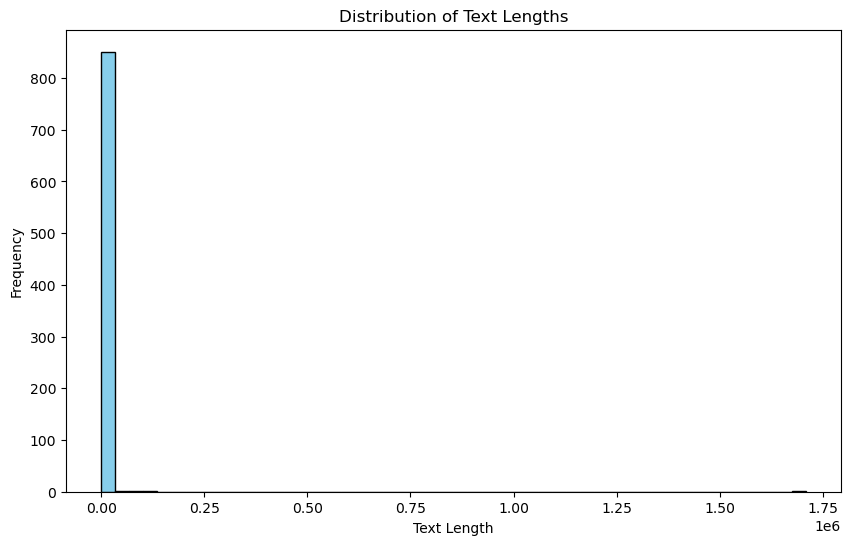

In [11]:
import matplotlib.pyplot as plt

data['content_length'] = data['cleaned_content'].apply(len)

print(data['content_length'].describe())

# length distribution
plt.figure(figsize=(10, 6))
plt.hist(data['content_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [12]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a function to tokenize text data with truncation and padding
def tokenize_data(texts, tokenizer, max_length=1024):
    """
    Tokenize input text data using BERT tokenizer.
    Parameters:
        texts (list of str): List of text data to tokenize.
        tokenizer (BertTokenizer): Pre-trained BERT tokenizer.
        max_length (int): Maximum sequence length for padding/truncation.
    Returns:
        dict: Dictionary with tokenized input_ids, attention_mask.
    """
    return tokenizer(
        texts,
        truncation=True,         # Truncate sequences to max_length
        padding="max_length",    # Pad sequences to max_length
        max_length=max_length,   # Maximum sequence length
        return_tensors="pt"      # Return PyTorch tensors
    )

# Tokenize the text data (cleaned_content column)
max_length = 512  # Define the fixed sequence length
encodings = tokenize_data(data['cleaned_content'].tolist(), tokenizer, max_length=max_length)

# Check the shape of tokenized inputs
print(f"Shape of input_ids: {encodings['input_ids'].shape}")        # Shape of token IDs
print(f"Shape of attention_mask: {encodings['attention_mask'].shape}")  # Shape of attention mask


Shape of input_ids: torch.Size([856, 512])
Shape of attention_mask: torch.Size([856, 512])


In [13]:
import torch
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    """
    Custom PyTorch Dataset for text classification.
    This class combines tokenized inputs and labels.
    """
    def __init__(self, encodings, labels):
        """
        Initialize the dataset with tokenized inputs and labels.
        Parameters:
            encodings (dict): Tokenized input data (input_ids and attention_mask).
            labels (list or torch.Tensor): Corresponding labels for the data.
        """
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Parameters:
            idx (int): Index of the sample to retrieve.
        Returns:
            dict: A dictionary containing input_ids, attention_mask, and labels.
        """
        item = {key: val[idx] for key, val in self.encodings.items()}  # input_ids and attention_mask
        item['labels'] = self.labels[idx]  # Add the label
        return item

# Prepare labels
labels = data['label_encoded'].tolist()  # Extract labels as a list

# Create dataset instance
dataset = TextClassificationDataset(encodings, labels)

# Check the dataset
print(f"Number of samples in the dataset: {len(dataset)}")
print("Example of a dataset sample:")
print(dataset[0])  # Display the first sample


Number of samples in the dataset: 856
Example of a dataset sample:
{'input_ids': tensor([  101, 22042,  3696,  5993,  2744,  4650,  3191,  9394,  3343,  3696,
         1999,  6279,  2591,  4070,  2180,  2102,  2695,  4070, 20786,  2442,
         2421,  3696,  1999,  6279,  2591,  4070,  2180,  2102,  2695,  4070,
        20786,  2442,  2421,  2064,  2102,  2767,  2208,  5045,  2067, 28997,
         4971,  2047,  2299, 20739,  2491,  2028,  2154,  4971,  3333,  4487,
         2015,  2650,  6136,  2402,  5003,  1051,  9541,  2226,  2226,  2226,
         6160,  2225,  7110,  2102,  2166, 11623,  2994, 12065,  2102,  2175,
         2078,  2707,  2514,  2066,  3190,  2562,  4172,  2072, 19808,  3501,
         3903, 14406,  2208,  9680, 20739,  2491,  2207,  9857,  2244, 18592,
         3128,  4431,  4971, 11155, 13552,  7867, 15969,  4679,  7867,  6884,
         5745, 15994,  9680,  4691,  5598, 15969,  4679,  2123,  2102, 15121,
         2051,  2175,  2852, 10993,  9096,  2123,  2102,  968

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset into training and validation sets
train_size = 0.8  # Proportion of data used for training
train_indices, val_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=1 - train_size, 
    random_state=42
)

# Subset the dataset for training and validation
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Define DataLoaders for training and validation
batch_size = 16  # Define batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the size of each set
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 684
Number of validation samples: 172


In [19]:
from transformers import BertForSequenceClassification

# Define the number of classes (unique labels in the dataset)
num_labels = len(data['label_encoded'].unique())+1
print("num_labels are", num_labels)
# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",    # Pre-trained BERT model
    num_labels=num_labels   # Number of output classes
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded and moved to device: {device}")


num_labels are 26


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device: cpu


In [20]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define loss function (for classification tasks)
loss_fn = CrossEntropyLoss()

# Optionally, define a learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Decays learning rate every 2 epochs

print("Optimizer, loss function, and scheduler initialized.")


Optimizer, loss function, and scheduler initialized.


/Users/a123/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from tqdm import tqdm
import torch

# Define the training loop
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    """
    Train the model for one epoch.
    Parameters:
        model (torch.nn.Module): BERT model with classification head.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (function): Loss function (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer (e.g., AdamW).
        device (torch.device): Device to run the training on (CPU or GPU).
    Returns:
        float: Average loss over the epoch.
    """
    model.train()  # Set model to training mode
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()  # Clear gradients from the previous step

        # Move batch data to the target device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Return average loss
    return total_loss / len(data_loader)


# Define the validation loop
def eval_model(model, data_loader, loss_fn, device):
    """
    Evaluate the model on the validation set.
    Parameters:
        model (torch.nn.Module): BERT model with classification head.
        data_loader (DataLoader): DataLoader for validation data.
        loss_fn (function): Loss function (e.g., CrossEntropyLoss).
        device (torch.device): Device to run the evaluation on (CPU or GPU).
    Returns:
        tuple: (average loss, accuracy)
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch data to the target device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [22]:
# Define the number of training epochs
num_epochs = 10  # You can adjust based on your dataset and task

# Track training progress
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

# Main training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    # Train the model for one epoch
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Training loss: {train_loss:.4f}")

    # Evaluate the model on the validation set
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn, device)
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # Save metrics for plotting or analysis
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)

    # Update learning rate (if using a scheduler)
    if scheduler:
        scheduler.step()

# Print summary of training
print("\nTraining complete!")
print(f"Best validation accuracy: {max(history['val_accuracy']):.4f}")



Epoch 1/10
------------------------------


Training:   0%|          | 0/43 [00:00<?, ?it/s]

Training:  65%|██████▌   | 28/43 [07:33<04:24, 17.67s/it]

In [16]:
# Split off a test set if not already done
from sklearn.model_selection import train_test_split

_, test_indices = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=42)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")


Number of test samples: 167


In [17]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a given dataset.
    Parameters:
        model (torch.nn.Module): Trained model to evaluate.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to perform evaluation on.
    Returns:
        dict: Evaluation metrics including accuracy and classification report.
    """
    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            # Move batch data to the target device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Store predictions and true labels
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, output_dict=True)

    return {"accuracy": accuracy, "classification_report": report}


In [18]:
# Evaluate the model on the test set
results = evaluate_model(model, test_loader, device)

# Print accuracy
print(f"Test Accuracy: {results['accuracy']:.4f}")

# Print classification report
from pprint import pprint
print("\nClassification Report:")
pprint(results['classification_report'])


Test Accuracy: 0.7246

Classification Report:
{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 3},
 '10': {'f1-score': 0.5142857142857143,
        'precision': 0.6,
        'recall': 0.45,
        'support': 20},
 '11': {'f1-score': 0.8043478260869565,
        'precision': 0.6981132075471698,
        'recall': 0.9487179487179487,
        'support': 39},
 '12': {'f1-score': 0.7619047619047619,
        'precision': 0.6349206349206349,
        'recall': 0.9523809523809523,
        'support': 42},
 '13': {'f1-score': 0.8999999999999999,
        'precision': 0.9642857142857143,
        'recall': 0.84375,
        'support': 32},
 '14': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 3},
 '2': {'f1-score': 0.8235294117647058,
       'precision': 1.0,
       'recall': 0.7,
       'support': 10},
 '4': {'f1-score': 0.5,
       'precision': 1.0,
       'recall': 0.3333333333333333,
       'support': 3},
 '5': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'su

/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
data['label_encoded'].value_counts()

12    157
11    127
13     81
10     66
9      45
2      27
14     23
1      10
4       7
6       6
3       2
8       2
0       1
7       1
5       1
Name: label_encoded, dtype: int64

# BiLSTM

In [23]:
pip install torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 8.4 MB/s eta 0:00:0000:01m0:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 7.3 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.0 requires torch==2.2.0, but you have torch 2.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

# Tokenizer
tokenizer = get_tokenizer("basic_english")

# Build vocabulary from training texts
counter = Counter()
for text in train_texts:  # `train_texts` 是训练集的文本列表
    counter.update(tokenizer(text))

# Create vocabulary with minimum frequency of 2
vocab = Vocab(counter, specials=["<unk>", "<pad>"], min_freq=2)

# Index for padding and unknown tokens
pad_idx = vocab["<pad>"]
unk_idx = vocab["<unk>"]

# Check vocabulary size and examples
print(f"Vocabulary size: {len(vocab)}")
print(f"Example tokens: {vocab.itos[:10]}")  # First 10 tokens in vocabulary


OSError: dlopen(/Users/a123/anaconda3/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN3c104impl3cow23materialize_cow_storageERNS_11StorageImplE
  Referenced from: <5436ECC1-6F45-386E-B542-D5F76A22B52C> /Users/a123/anaconda3/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so
  Expected in:     <E4A087BF-2A73-36B5-9B71-18B1A776D3D4> /Users/a123/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib

In [30]:
import torch
import torchtext

print(f"torch version: {torch.__version__}")
print(f"torchtext version: {torchtext.__version__}")


OSError: dlopen(/Users/a123/anaconda3/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <E56EB320-C4AC-37D0-8A24-935CA6B32161> /Users/a123/anaconda3/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so
  Expected in:     <44DEDA27-4DE9-3D4A-8EDE-5AA72081319F> /Users/a123/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib

In [27]:
pip install torch==2.0.0 torchtext==0.15.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 8.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00a 0:00:01m
Reason for being yanked: Contains an incorrect dependency on torch
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.0 requires torch==2.2.0, but you have torch 2.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [28]:
conda install pytorch==2.0.0 torchtext==0.15.0 -c pytorch


Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - torchtext==0.15.0 -> python[version='>=3.10,<3.11.0a0|>=3.8,<3.9.0a0|>=3.9,<3.10.0a0']

Your python: python=3.11

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change you